In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()  # This sets the seaborn theme directly
plt.rcParams['figure.figsize'] = [12, 6]

# Load the enriched dataset
df = pd.read_csv('../data/enriched_merged_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Loaded data with shape: {df.shape}")
print("\nColumns available:", ', '.join(df.columns))


Loaded data with shape: (3765, 15)

Columns available: Date, Open, High, Low, Close, Volume, Dividends, Stock splits, Ticker, EMA10, EMA50, RSI, MACD, MACD_Signal, MACD_Hist


C:\Users\techs\AppData\Local\Temp\ipykernel_165580\2674351948.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
# Function to calculate forward returns and generate labels
def generate_labels(stock_df):
    """
    Calculate forward returns and generate trading signals.
    
    Args:
        stock_df (pd.DataFrame): DataFrame for a single stock
        
    Returns:
        pd.DataFrame: DataFrame with added labels
    """
    df = stock_df.copy()
    
    # Calculate 1-day forward returns
    df['future_return'] = df['Close'].shift(-1) / df['Close'] - 1
    
    # Generate trading signals based on thresholds
    conditions = [
        (df['future_return'] > 0.01),  # Buy signal: >1% return
        (df['future_return'] < -0.01),  # Sell signal: <-1% return
    ]
    choices = ['Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    
    # Create numerical labels
    label_map = {'Buy': 1, 'Sell': -1, 'Hold': 0}
    df['y'] = df['Signal'].map(label_map)
    
    return df

# Process each stock separately to avoid lookahead bias
final_dfs = []
for ticker in df['Ticker'].unique():
    # Get data for this ticker
    stock_df = df[df['Ticker'] == ticker].sort_values('Date')
    
    # Generate labels
    labeled_df = generate_labels(stock_df)
    
    # Add to list
    final_dfs.append(labeled_df)
    
    print(f"\nClass distribution for {ticker}:")
    print(labeled_df['Signal'].value_counts(normalize=True).round(3))

# Combine all processed data
final_df = pd.concat(final_dfs, axis=0)
final_df = final_df.sort_values(['Date', 'Ticker'])

# Remove last row for each stock (no forward return available)
final_df = final_df.dropna(subset=['future_return'])



Class distribution for AAPL:
Signal
Hold    0.512
Buy     0.266
Sell    0.222
Name: proportion, dtype: float64

Class distribution for MSFT:
Signal
Hold    0.528
Buy     0.262
Sell    0.210
Name: proportion, dtype: float64

Class distribution for TSLA:
Signal
Buy     0.379
Sell    0.359
Hold    0.262
Name: proportion, dtype: float64



Overall class distribution:
Signal
Hold    0.434
Buy     0.303
Sell    0.264
Name: proportion, dtype: float64


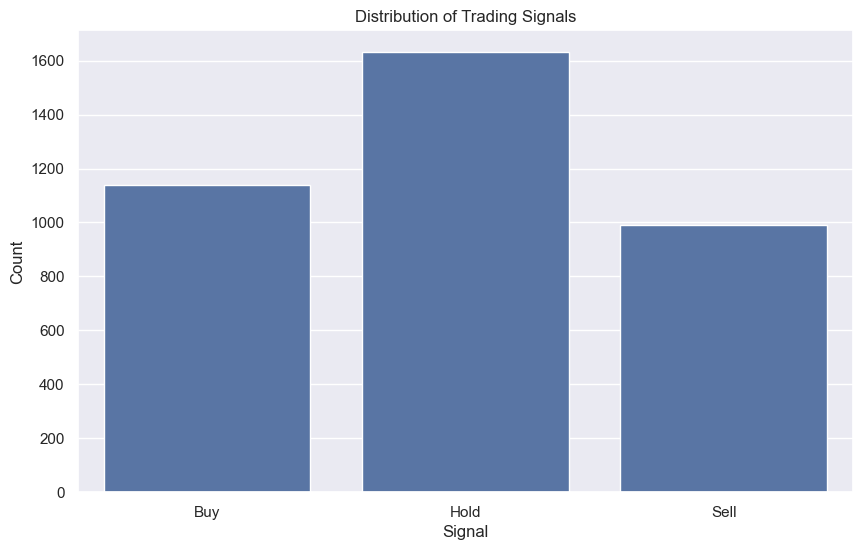

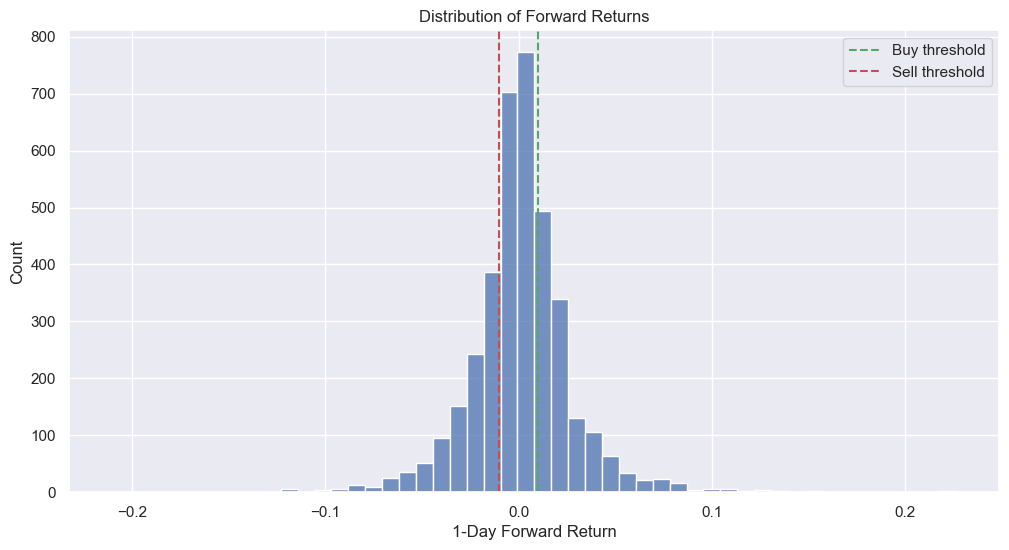


Saved final dataset to: ../data/final_model_data.csv
Final shape: (3762, 18)


In [4]:
# Analyze overall class distribution
print("\nOverall class distribution:")
print(final_df['Signal'].value_counts(normalize=True).round(3))

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='Signal', order=['Buy', 'Hold', 'Sell'])
plt.title('Distribution of Trading Signals')
plt.ylabel('Count')
plt.show()

# Plot returns distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=final_df, x='future_return', bins=50)
plt.axvline(x=0.01, color='g', linestyle='--', label='Buy threshold')
plt.axvline(x=-0.01, color='r', linestyle='--', label='Sell threshold')
plt.title('Distribution of Forward Returns')
plt.xlabel('1-Day Forward Return')
plt.legend()
plt.show()

# Save final dataset
output_path = '../data/final_model_data.csv'
final_df.to_csv(output_path, index=False)
print(f"\nSaved final dataset to: {output_path}")
print(f"Final shape: {final_df.shape}")
